<a href="https://colab.research.google.com/github/yuvalira/Final-Project-Adversarial-Attack-on-Tabular-Classification/blob/main/ATTACK/GBT_Attack.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import pandas as pd
import joblib
from scipy.stats import pointbiserialr
import numpy as np
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, precision_score, recall_score, f1_score
import pickle
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from random import sample
from matplotlib.patches import FancyArrowPatch
import matplotlib.patheffects as pe
import torch
from transformers import RobertaTokenizer, RobertaForMaskedLM
from huggingface_hub import hf_hub_download

# **Adversarial Attack**

### 1. Get Model and Data from Git

In [2]:
# Git clone
REPO_URL = "https://github.com/yuvalira/Final-Project-Adversarial-Attack-on-Tabular-Classification.git"
!git clone {REPO_URL}
%cd Final-Project-Adversarial-Attack-on-Tabular-Classification

# Read test dataset
test_data = pd.read_csv('data/test_data.csv')
print(f"test_data loaded: {test_data.shape}")

# Read GBT model (sklearn)
model_path = 'GBT/sklearn_GBT_model.joblib'
assert os.path.exists(model_path), f"Model file not found at {model_path}"

model_gbt = joblib.load(model_path)
print("sklearn GBT model loaded successfully.")

# Load label encoders for decoding categorical features
with open('data/label_encoders.pkl', 'rb') as f:
    encoders = pickle.load(f)
print("Label encoders loaded successfully.")

Cloning into 'Final-Project-Adversarial-Attack-on-Tabular-Classification'...
remote: Enumerating objects: 244, done.
remote: Counting objects: 100% (76/76), done.
remote: Compressing objects: 100% (63/63), done.
remote: Total 244 (delta 40), reused 13 (delta 13), pack-reused 168 (from 1)
Receiving objects: 100% (244/244), 5.93 MiB | 13.05 MiB/s, done.
Resolving deltas: 100% (99/99), done.
/content/Final-Project-Adversarial-Attack-on-Tabular-Classification
test_data loaded: (9769, 15)
sklearn GBT model loaded successfully.
Label encoders loaded successfully.


In [3]:
repo_id = "ETdanR/RoBERTa_FT_adult" # This is the same repo where your model is


csv_filename = "experiment_data.csv"
csv_path = hf_hub_download(repo_id=repo_id, filename=csv_filename)
experiment_data = pd.read_csv(csv_path)



/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


experiment_data.csv:   0%|          | 0.00/933k [00:00<?, ?B/s]

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load fine-tuned model directly from Hugging Face Hub
model_path = "ETdanR/RoBERTa_FT_adult"
tokenizer = RobertaTokenizer.from_pretrained(model_path)
model = RobertaForMaskedLM.from_pretrained(model_path)
model.eval()
model.to(device)

# Define mask token info
mask_token = tokenizer.mask_token
mask_token_id = tokenizer.mask_token_id

# Token IDs for income prediction (example IDs from your snippet)
greater_than_id = 9312  # "Greater"
less_than_id = 10862    # "Less"

Using device: cuda


tokenizer_config.json:   0%|          | 0.00/1.25k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.05M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/506k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/1.01k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/699 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

In [5]:
def predict_LM(df: pd.DataFrame) -> np.ndarray:
    """
    Generates predictions for a DataFrame of input features using a Language Model.
    Optimized for faster inference on batches by leveraging GPU and vectorized operations.

    Args:
        df (pd.DataFrame): A pandas DataFrame containing the features for which
                           to generate predictions. Each row represents a data point.

    Returns:
        np.ndarray: A NumPy array of predictions (0 for <=50K, 1 for >50K, -1 for unknown).
                    The shape is (batch_size,).
    """
    if tokenizer is None or model is None:
        print("Error: Hugging Face tokenizer or model not loaded. Returning random predictions.")
        return np.random.randint(0, 2, size=len(df)) # Return dummy predictions if model isn't loaded

    # 1. Sentence Generation (Current approach using iterrows is often acceptable for batch sizes)
    # This part is still Python-loop based, but typically not the biggest bottleneck compared to LM inference.
    sentences = []
    for _, row in df.iterrows():
        sentence_parts = [
            f"age: {row['age']}",
            f"workclass: {row['workclass']}",
            f"education: {row['education']}",
            f"educational-num: {row['educational-num']}",
            f"marital-status: {row['marital-status']}",
            f"occupation: {row['occupation']}",
            f"relationship: {row['relationship']}",
            f"race: {row['race']}",
            f"gender: {row['gender']}",
            f"capital-gain: {row['capital-gain']}",
            f"capital-loss: {row['capital-loss']}",
            f"hours-per-week: {row['hours-per-week']}",
            f"native-country: {row['native-country']}"
        ]

        # Always include the income field with a mask token, regardless of whether
        # the 'income' column is present in the input DataFrame.
        # This ensures the model always has a masked position to predict.
        sentence_parts.append(f"income: {mask_token} than 50k")

        sentences.append(", ".join(sentence_parts))

    # 2. Tokenization and Device Placement
    # Move encoded inputs to the same device as the model (GPU if available)
    encoded = tokenizer(
        sentences,
        return_tensors='pt',
        padding=True,
        truncation=True,
        max_length=128
    ).to(device) # <--- Optimization: Move tensors to device

    # 3. Model Inference (using torch.no_grad() or torch.inference_mode())
    # `torch.inference_mode()` is newer and potentially faster for inference (PyTorch 1.9+)
    with torch.no_grad(): # Use torch.inference_mode() if PyTorch version >= 1.9
        outputs = model(**encoded)
        logits = outputs.logits # Logits are already on the device

    # 4. Vectorized Mask Position Extraction
    # Find all occurrences of mask_token_id.
    # `nonzero(as_tuple=True)` returns a tuple of 1D tensors: (batch_indices, token_indices_in_sequence).
    # This is more efficient than `as_tuple=False` followed by slicing in a loop.
    mask_batch_indices, mask_token_indices = (encoded['input_ids'] == mask_token_id).nonzero(as_tuple=True)

    # 5. Vectorized Prediction Mapping
    # Initialize a results tensor on the device, filled with -1 (for unprocessable/unflipped predictions)
    results_tensor = torch.full((len(df),), -1, dtype=torch.long, device=device)

    # Only proceed if at least one mask token was found in the batch
    if mask_batch_indices.numel() > 0:
        # Gather the logits specifically at the mask token positions for all relevant sentences
        # This is a vectorized operation.
        logits_at_mask = logits[mask_batch_indices, mask_token_indices]

        # Get the predicted token ID (argmax over the vocabulary dimension) for each mask position
        predicted_token_ids_at_mask = torch.argmax(logits_at_mask, dim=-1)

        # Map these predicted token IDs to 0 or 1 using vectorized torch.where
        # This replaces the Python `if/elif/else` loop.
        is_greater = (predicted_token_ids_at_mask == greater_than_id)
        is_less = (predicted_token_ids_at_mask == less_than_id)

        # Initialize a temporary tensor for mapped predictions for found masks
        mapped_predictions = torch.full_like(predicted_token_ids_at_mask, -1)
        mapped_predictions[is_greater] = 1
        mapped_predictions[is_less] = 0

        # Place these mapped predictions into the main results_tensor at their correct batch indices
        results_tensor[mask_batch_indices] = mapped_predictions

    # Move the final results back to CPU and convert to NumPy array
    results_np = results_tensor.cpu().numpy()

    # print("predict_LM called") # Uncomment for debugging
    return results_np

### 2. Prepare Data-Frames

Create Correct Predictions and Incorrect Predictions datasets

In [6]:
TARGET_COLUMN_NAME = 'income'

# Create a copy of test_data
test_data_attack = test_data.copy()

# Prepare test features
exclude_columns = [TARGET_COLUMN_NAME, 'fnlwgt']
X_test = test_data.drop(columns=exclude_columns)
y_true = test_data[TARGET_COLUMN_NAME].values

# Predict class labels (0/1)
y_pred = model_gbt.predict(X_test)

# Create a new column for prediction correctness
test_data_attack['correct_prediction'] = (y_true == y_pred)

# Create datasets for correct and incorrect predictions
correct_predictions_df = test_data_attack[test_data_attack['correct_prediction'] == True].drop(columns=['correct_prediction'])
incorrect_predictions_df = test_data_attack[test_data_attack['correct_prediction'] == False].drop(columns=['correct_prediction'])

print(f"Correct predictions shape : {correct_predictions_df.shape}")
print(f"Incorrect predictions shape : {incorrect_predictions_df.shape}")


Correct predictions shape : (8572, 15)
Incorrect predictions shape : (1197, 15)


### 3. Create Correlation Dictionary

We compute a correlation dictionary to guide and constrain the adversarial attack process.  
For each feature and possible value, we calculate the correlation between the presence of that value and the target label.

The correlation dictionary serves three key purposes:
1. **Feature Filtering:** Only features with correlation above a defined threshold are considered for attack.
2. **Feature Prioritization:** Features are sorted by correlation strength to guide the attack toward the most influential attributes first.
3. **Categorical Attack Control:** For categorical features, value changes are limited to neighboring values based on their position in the correlation dictionary, avoiding random or unrealistic jumps between categories.

In [7]:
def create_correlation_dict(df, target_column='income'):
    """
    Create a dictionary of correlation values between feature values and the target class.
    Used for driving adversarial attack modifications.
    """
    correlation_dict = {}
    target = df[target_column]
    features = df.drop(columns=[target_column, 'fnlwgt'])

    for col in features.columns:
        value_corrs = {}

        # Categorical or numerical feature
        if features[col].dtype == 'object' or features[col].dtype.name == 'category':
            unique_vals = features[col].unique()
        else:
            unique_vals = np.unique(features[col].values)

        for val in unique_vals:
            binary_vec = features[col].apply(lambda x: 1 if x == val else 0)
            try:
                corr, _ = pointbiserialr(binary_vec, target)
            except Exception:
                corr = 0

            # Clean numpy types
            if isinstance(val, (np.integer, np.int64)):
                val = int(val)

            value_corrs[val] = corr if not np.isnan(corr) else 0

        # Sort values by correlation descending
        correlation_dict[col] = dict(sorted(value_corrs.items(), key=lambda x: x[1], reverse=True))

    return correlation_dict

In [8]:
correlation_dict = create_correlation_dict(test_data_attack, target_column="income")

# Print correlation dict
for feature, val_corrs in correlation_dict.items():
    print(f"\nFeature: {feature}")
    for val, corr in val_corrs.items():
        # If feature is categorical and encoder exists → decode value
        if feature in encoders:
            val = encoders[feature].inverse_transform([int(val)])[0]
        print(f"    {val}: {corr:.4f}")


Feature: age
    46: 0.0693
    47: 0.0607
    42: 0.0597
    45: 0.0570
    50: 0.0561
    44: 0.0526
    48: 0.0465
    43: 0.0465
    52: 0.0446
    58: 0.0411
    38: 0.0410
    51: 0.0392
    54: 0.0387
    49: 0.0385
    57: 0.0373
    53: 0.0346
    41: 0.0323
    37: 0.0306
    40: 0.0301
    39: 0.0266
    36: 0.0262
    32: 0.0222
    59: 0.0211
    60: 0.0204
    85: 0.0183
    83: 0.0183
    61: 0.0145
    56: 0.0137
    55: 0.0133
    79: 0.0095
    34: 0.0069
    65: 0.0045
    81: 0.0030
    67: 0.0016
    62: 0.0007
    63: -0.0005
    64: -0.0010
    71: -0.0015
    77: -0.0018
    78: -0.0018
    70: -0.0025
    73: -0.0032
    69: -0.0037
    80: -0.0040
    35: -0.0043
    88: -0.0056
    90: -0.0069
    84: -0.0079
    74: -0.0082
    66: -0.0091
    31: -0.0099
    82: -0.0112
    76: -0.0114
    30: -0.0147
    68: -0.0163
    75: -0.0177
    72: -0.0251
    33: -0.0254
    29: -0.0323
    28: -0.0441
    27: -0.0543
    17: -0.0588
    24: -0.0606
    26: -0.06

### 4. Adversarial Attack Generation

This function generates adversarial examples by applying controlled perturbations to the input samples.  
The attack follows a structured approach to efficiently search for minimal changes that will flip the model's prediction:

1. **Input Selection:** Only correctly predicted samples are selected for the attack.
2. **Feature Selection:** Features are prioritized and filtered based on the correlation dictionary.
3. **Attack Loop:** For each sample:
   - For **numeric features**, the value is perturbed by adding or subtracting a small pre-defined delta.
   - For **categorical features**, the current value is replaced by neighboring values in the correlation dictionary (not random replacements).
   - After each change, the model is queried. If the prediction flips, the attack stops for that sample.

This method ensures that the attack remains realistic and focused on high-impact feature manipulations, avoiding excessive or implausible modifications.

In [9]:
def generate_adversarial_attack(
        df_test, model_gbt, correlation_dict, modelArch,
        max_features_changed=3,
        correlation_threshold=0.05, max_attempts=10):
    # Declare bounds for numeric features
    numeric_bounded_features = {
        'age': 5,
        'hours-per-week': 5,
        'capital-gain': 1000,
        'capital-loss': 1000,
        'educational-num': 2,
    }

    adv_samples = []
    success_count = 0
    df_types = df_test.dtypes.to_dict()

    # Prepare test set
    exclude_columns = [TARGET_COLUMN_NAME, 'fnlwgt']
    X_test = df_test.drop(columns=exclude_columns)
    y_true = df_test[TARGET_COLUMN_NAME].values
    y_pred_orig = model_gbt.predict(X_test) if modelArch == "GBT" else predict_LM(X_test)

    # Prioritize features by correlation
    priorities = []
    for feature in correlation_dict.keys():
        if feature == TARGET_COLUMN_NAME or feature not in df_test.columns:
            continue
        values = correlation_dict[feature].values()
        max_corr = max(abs(v) for v in values if v is not None)
        if max_corr >= correlation_threshold:
            priorities.append((feature, max_corr))

    priorities.sort(key=lambda x: x[1], reverse=True)
    ordered_features = [f[0] for f in priorities]

    for idx in range(len(df_test)):
        original_input = df_test.iloc[[idx]]
        original_label = original_input[TARGET_COLUMN_NAME].values[0]
        current_sample = original_input.iloc[0].copy()
        changed_features = set()
        success = False
        attempts = 0

        while len(changed_features) < max_features_changed and attempts < max_attempts:
            attempts += 1
            current_X = pd.DataFrame([current_sample.drop(labels=[TARGET_COLUMN_NAME, 'fnlwgt'])])
            current_pred = model_gbt.predict(current_X)[0] if modelArch == "GBT" else predict_LM(current_X)[0]

            if current_pred != original_label:
                success = True
                break

            candidate_samples = []
            candidate_features = []

            for feature in ordered_features:
                if feature in changed_features:
                    continue

                current_value = current_sample[feature]

                # Numeric feature
                if feature in numeric_bounded_features:
                    delta = numeric_bounded_features[feature]
                    try:
                        current_value = float(current_value)
                        for new_val in [current_value + delta, max(0, current_value - delta)]:
                            trial_sample = current_sample.copy()
                            trial_sample[feature] = new_val
                            candidate_samples.append(trial_sample)
                            candidate_features.append(feature)
                    except:
                        continue

                # Categorical feature
                else:
                    possible_vals = list(correlation_dict[feature].keys())
                    current_value_int = int(current_value) if isinstance(current_value,
                                                                         (np.integer, np.int64)) else current_value
                    try:
                        idx_val = possible_vals.index(current_value_int)
                    except ValueError:
                        continue

                    neighbors = []
                    if idx_val - 2 >= 0:
                        neighbors.append(possible_vals[idx_val - 2])
                    if idx_val + 2 < len(possible_vals):
                        neighbors.append(possible_vals[idx_val + 2])
                    if not neighbors and len(possible_vals) > 1:
                        if idx_val > 0:
                            neighbors.append(possible_vals[idx_val - 1])
                        if idx_val < len(possible_vals) - 1:
                            neighbors.append(possible_vals[idx_val + 1])

                    for neighbor_val in neighbors:
                        trial_sample = current_sample.copy()
                        trial_sample[feature] = neighbor_val
                        candidate_samples.append(trial_sample)
                        candidate_features.append(feature)

                if len(candidate_samples) >= 20:
                    break

            if not candidate_samples:
                break

            batch_X = pd.DataFrame(candidate_samples)[
                [col for col in current_sample.index if col not in [TARGET_COLUMN_NAME, 'fnlwgt']]]
            batch_preds = model_gbt.predict(batch_X) if modelArch == "GBT" else predict_LM(batch_X)

            for i, pred in enumerate(batch_preds):
                if int(pred) != original_label:
                    current_sample = candidate_samples[i]
                    changed_features.add(candidate_features[i])
                    break

        adv_samples.append(current_sample.astype(object))
        if success:
            success_count += 1

    adv_df = pd.DataFrame(adv_samples).astype(df_types)

    # Evaluation
    adv_X = adv_df.drop(columns=[TARGET_COLUMN_NAME, 'fnlwgt'])
    y_pred_adv = model_gbt.predict(adv_X) if modelArch == "GBT" else predict_LM(adv_X)

    flipped = sum(y_pred_orig != y_pred_adv)
    print(f"\n Attack success: {success_count}/{len(df_test)} ({(success_count / len(df_test)) * 100:.2f}%)")
    print(f" Original accuracy: {accuracy_score(y_true, y_pred_orig):.2%}")
    print(f" Adversarial accuracy: {accuracy_score(y_true, y_pred_adv):.2%}")

    return adv_df

# **Attack GBT Model**

## 1. Apply Attack

Now, we apply the adversarial attack on the set of correctly predicted test samples from the Gradient Boosted Trees (GBT) model.  

This step generates the adversarial dataset (`adv_test_df`) used for further evaluation and analysis.


In [10]:
# Select subset of samples to attack
samples_to_attack = correct_predictions_df.copy()

# Run adversarial attack
adv_test_df = generate_adversarial_attack(
    df_test=samples_to_attack,
    model_gbt=model_gbt,
    correlation_dict=correlation_dict,
    modelArch = "GBT"
)

print(f"\n Attack finished. Adversarial test set shape: {adv_test_df.shape}")


 Attack success: 1752/8572 (20.44%)
 Original accuracy: 100.00%
 Adversarial accuracy: 79.56%

 Attack finished. Adversarial test set shape: (8572, 15)


In [84]:
print(adv_test_df.head())

   age  workclass  fnlwgt  education  educational-num  marital-status  \
0   56          4   33115         11                9               0   
1   25          4  112847         11                9               2   
2   43          4  170525          9               13               0   
3   32          4  186788         11                9               2   
5   20          4  323009         11                9               4   

   occupation  relationship  race  gender  capital-gain  capital-loss  \
0           8             4     4       0             0             0   
1          14             3     3       1             0             0   
2          10             1     4       0         14344             0   
3          14             0     4       1             0             0   
5           1             4     4       0             0             0   

   hours-per-week  native-country  income  
0              40              39       0  
1              40              39 

## 2. Attack Evaluation

In [11]:
def analyze_attack_changes(original_df, adversarial_df, label_column='income', verbose=True, max_samples_to_print=10):
    """
    Analyze feature changes between original and adversarial samples.
    Returns: list of differences per sample, and feature change counts.
    Only prints up to max_samples_to_print changed samples for readability.
    """
    feature_names = [f for f in original_df.columns if f not in [label_column, 'fnlwgt']]
    change_counts = {feature: 0 for feature in feature_names}
    total_samples = len(original_df)

    all_diffs = []
    printed_samples = 0

    for idx in range(total_samples):
        orig_row = original_df.iloc[idx]
        adv_row = adversarial_df.iloc[idx]
        diffs = {}
        for feature in feature_names:
            if orig_row[feature] != adv_row[feature]:
                old_val = orig_row[feature]
                new_val = adv_row[feature]

                # decode categorical values back to original labels
                if feature in encoders:
                    try:
                        old_val = encoders[feature].inverse_transform([int(old_val)])[0]
                        new_val = encoders[feature].inverse_transform([int(new_val)])[0]
                    except Exception:
                        pass  # in case of any weird value, just keep as is

                diffs[feature] = (old_val, new_val)
                change_counts[feature] += 1

        all_diffs.append(diffs)

        if verbose and diffs and printed_samples < max_samples_to_print:
            print(f"\nSample {idx}: {len(diffs)} feature(s) changed:")
            for feat, (old, new) in diffs.items():
                print(f"  {feat}: {old} → {new}")
            printed_samples += 1

    # Summary
    print("\n--- Global Feature Change Statistics ---")
    for feature, count in change_counts.items():
        print(f"{feature}: changed in {count}/{total_samples} samples ({(count/total_samples)*100:.2f}%)")

    print("\n Attack analysis completed.")
    return all_diffs, change_counts

In [12]:
all_diffs, change_counts = analyze_attack_changes(
    original_df=samples_to_attack,
    adversarial_df=adv_test_df,
    label_column='income'
)


Sample 6: 1 feature(s) changed:
  relationship: Wife → Unmarried

Sample 12: 1 feature(s) changed:
  relationship: Other-relative → Husband

Sample 13: 1 feature(s) changed:
  educational-num: 11 → 13

Sample 17: 1 feature(s) changed:
  capital-loss: 1408 → 2408

Sample 18: 1 feature(s) changed:
  capital-loss: 3004 → 2004

Sample 24: 1 feature(s) changed:
  age: 24 → 29

Sample 26: 1 feature(s) changed:
  relationship: Wife → Unmarried

Sample 27: 1 feature(s) changed:
  relationship: Husband → Other-relative

Sample 38: 1 feature(s) changed:
  educational-num: 9 → 11

Sample 43: 1 feature(s) changed:
  relationship: Unmarried → Wife

--- Global Feature Change Statistics ---
age: changed in 33/8572 samples (0.38%)
workclass: changed in 23/8572 samples (0.27%)
education: changed in 28/8572 samples (0.33%)
educational-num: changed in 221/8572 samples (2.58%)
marital-status: changed in 139/8572 samples (1.62%)
occupation: changed in 166/8572 samples (1.94%)
relationship: changed in 829/

**Model Robustness Comparison**

Now, we will evaluate the model on both the original test set and the full attacked test set.  


In [13]:
# Predict on original test set (before attack)
X_original = test_data.drop(columns=['income', 'fnlwgt'])
y_original = test_data['income']

y_pred_original = model_gbt.predict(X_original)

# Combine attacked + incorrect samples to create full attacked dataset
full_attacked_test_data = pd.concat([adv_test_df, incorrect_predictions_df], axis=0).reset_index(drop=True)

X_attacked = full_attacked_test_data.drop(columns=['income', 'fnlwgt'])
y_attacked = full_attacked_test_data['income']

y_pred_attacked = model_gbt.predict(X_attacked)

# Calculate metrics for original test set
original_accuracy = accuracy_score(y_original, y_pred_original)
original_precision = precision_score(y_original, y_pred_original)
original_recall = recall_score(y_original, y_pred_original)
original_f1 = f1_score(y_original, y_pred_original)

# Calculate metrics for attacked test set
attacked_accuracy = accuracy_score(y_attacked, y_pred_attacked)
attacked_precision = precision_score(y_attacked, y_pred_attacked)
attacked_recall = recall_score(y_attacked, y_pred_attacked)
attacked_f1 = f1_score(y_attacked, y_pred_attacked)

# Print comparison
print("\n Model Performance Comparison:")
print(f" Original Accuracy: {original_accuracy:.4f} | Attacked Accuracy: {attacked_accuracy:.4f}")
print(f" Original Precision: {original_precision:.4f} | Attacked Precision: {attacked_precision:.4f}")
print(f" Original Recall: {original_recall:.4f} | Attacked Recall: {attacked_recall:.4f}")
print(f" Original F1-Score: {original_f1:.4f} | Attacked F1-Score: {attacked_f1:.4f}")

# Accuracy drop
drop = original_accuracy - attacked_accuracy
print(f"\n Accuracy drop due to attack: {drop:.4f} ({drop*100:.2f}% drop)")



 Model Performance Comparison:
 Original Accuracy: 0.8775 | Attacked Accuracy: 0.6981
 Original Precision: 0.7709 | Attacked Precision: 0.3340
 Original Recall: 0.6790 | Attacked Recall: 0.2895
 Original F1-Score: 0.7221 | Attacked F1-Score: 0.3102

 Accuracy drop due to attack: 0.1793 (17.93% drop)


**ROC Curve Comparison Before and After Attack**

We compare the Receiver Operating Characteristic (ROC) curves of the model on the original test set and after the adversarial attack.  
A lower ROC curve and AUC after attack indicates degradation of the model's classification ability.

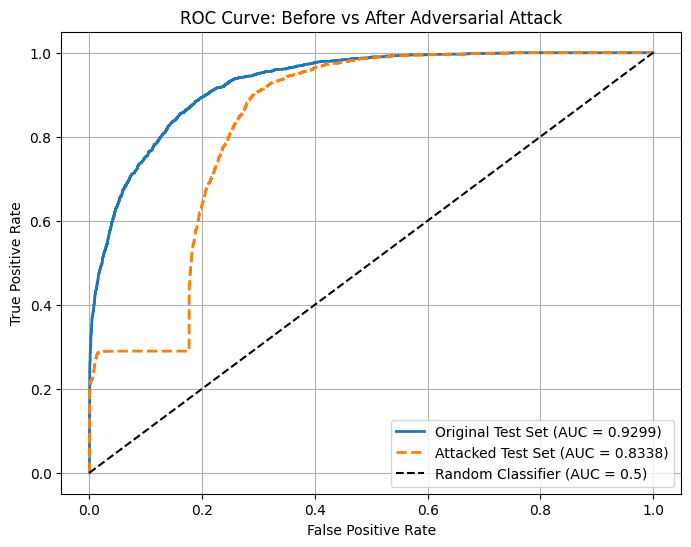

In [14]:
# Original test set
X_original = test_data.drop(columns=['income', 'fnlwgt'])
y_original = test_data['income']
y_score_original = model_gbt.predict_proba(X_original)[:, 1]
auc_original = roc_auc_score(y_original, y_score_original)
fpr_original, tpr_original, _ = roc_curve(y_original, y_score_original)

# Attacked test set
X_attacked = full_attacked_test_data.drop(columns=['income', 'fnlwgt'])
y_attacked = full_attacked_test_data['income']
y_score_attacked = model_gbt.predict_proba(X_attacked)[:, 1]
auc_attacked = roc_auc_score(y_attacked, y_score_attacked)
fpr_attacked, tpr_attacked, _ = roc_curve(y_attacked, y_score_attacked)

# Plot both curves
plt.figure(figsize=(8,6))
plt.plot(fpr_original, tpr_original, label=f"Original Test Set (AUC = {auc_original:.4f})", linewidth=2)
plt.plot(fpr_attacked, tpr_attacked, label=f"Attacked Test Set (AUC = {auc_attacked:.4f})", linewidth=2, linestyle='--')
plt.plot([0, 1], [0, 1], 'k--', label="Random Classifier (AUC = 0.5)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve: Before vs After Adversarial Attack")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


The ROC curve comparison shows a significant reduction in model performance under adversarial attack.  
The AUC dropped from 0.9299 to 0.8351, demonstrating that the structured attack succeeded in reducing the model's ability to distinguish between income classes.

**PCA**

In this analysis, we applied PCA (Principal Component Analysis) to two datasets: one before an adversarial attack and one after.

The purpose of PCA is to project high-dimensional data into a lower-dimensional space (2D) while preserving as much variance (information) as possible.
This allows us to:


*   Visually compare the distribution of data before and after the attack.
*   Observe whether the attack caused meaningful changes in the data structure.
*   Identify if there is a visual separation between the two datasets, which may indicate that the attack significantly altered the features.

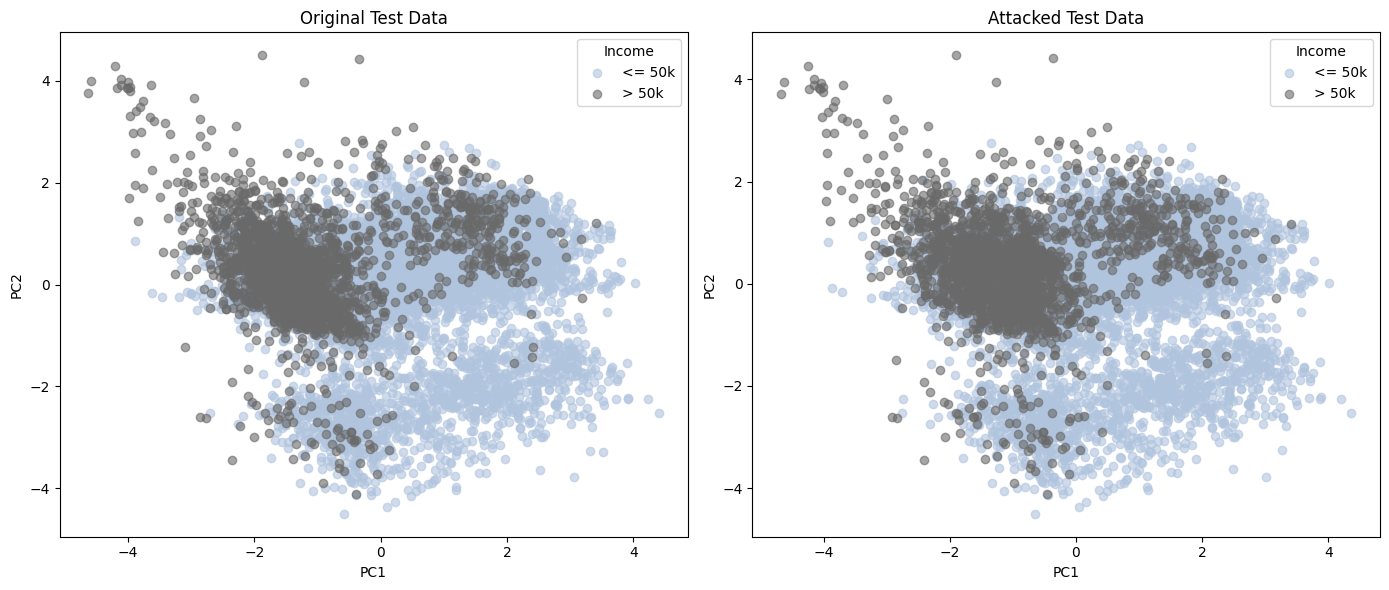

In [15]:
# Map numeric labels to class names
class_map = {
    0: '<= 50k',
    1: '> 50k'
}

# Define colors for each class name
custom_colors = {
    '<= 50k': 'lightsteelblue',  # light blue
    '> 50k': 'dimgrey'  # gray
}

# Preprocess function
def preprocess(df, label_column='income'):
    raw_labels = df[label_column].values
    labels = np.vectorize(class_map.get)(raw_labels)  # convert to class names
    features = df.drop(columns=[label_column])
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)
    return features_scaled, labels

# Preprocess datasets
X_original, y_original = preprocess(test_data, label_column='income')
X_attacked, y_attacked = preprocess(full_attacked_test_data, label_column='income')

# PCA
pca = PCA(n_components=2)
X_original_pca = pca.fit_transform(X_original)
X_attacked_pca = pca.transform(X_attacked)

# Plot
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Original
for label in np.unique(y_original):
    idx = y_original == label
    axes[0].scatter(X_original_pca[idx, 0], X_original_pca[idx, 1],
                    c=custom_colors[label], label=label, alpha=0.6)
axes[0].set_title('Original Test Data')
axes[0].set_xlabel('PC1')
axes[0].set_ylabel('PC2')
axes[0].legend(title='Income')

# Attacked
for label in np.unique(y_attacked):
    idx = y_attacked == label
    axes[1].scatter(X_attacked_pca[idx, 0], X_attacked_pca[idx, 1],
                    c=custom_colors[label], label=label, alpha=0.6)
axes[1].set_title('Attacked Test Data')
axes[1].set_xlabel('PC1')
axes[1].set_ylabel('PC2')
axes[1].legend(title='Income')

plt.tight_layout()
plt.show()

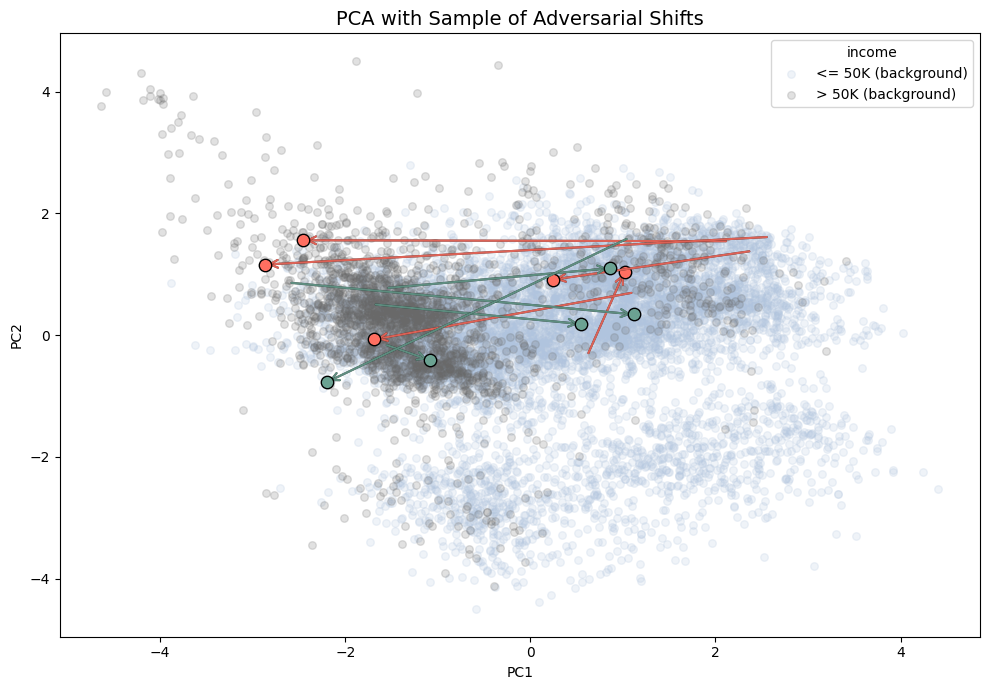

In [16]:
# Class name map
class_map = {0: '<= 50K', 1: '> 50K'}

# Soft transition colors
transition_colors = {
    (0, 1): '#FF6F61',  # coral rose
    (1, 0): '#6BA292'   # eucalyptus green
}

# Background colors
background_colors = {
    0: 'lightsteelblue',
    1: 'dimgrey'
}

# Preprocess
def preprocess(df, label_column='income'):
    labels = df[label_column].values.astype(int)
    features = df.drop(columns=[label_column])
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)
    return features_scaled, labels

# Prepare data
X_original, y_original = preprocess(test_data)
X_attacked, y_attacked = preprocess(full_attacked_test_data)

# Changed samples
changed_idx = np.where(y_original != y_attacked)[0]
X_orig_changed = X_original[changed_idx]
X_att_changed = X_attacked[changed_idx]
y_from = y_original[changed_idx]
y_to = y_attacked[changed_idx]

# Select 5 from each transition
transition_01 = np.where((y_from == 0) & (y_to == 1))[0]
transition_10 = np.where((y_from == 1) & (y_to == 0))[0]
selected_01 = sample(list(transition_01), min(5, len(transition_01)))
selected_10 = sample(list(transition_10), min(5, len(transition_10)))
selected_idx = selected_01 + selected_10

X_orig_sel = X_orig_changed[selected_idx]
X_att_sel = X_att_changed[selected_idx]
y_from_sel = y_from[selected_idx]
y_to_sel = y_to[selected_idx]

# PCA
pca = PCA(n_components=2)
X_original_pca = pca.fit_transform(X_original)
X_orig_pca_sel = pca.transform(X_orig_sel)
X_att_pca_sel = pca.transform(X_att_sel)

# Plot
fig, ax = plt.subplots(figsize=(10, 7))

# Background
for label in np.unique(y_original):
    idx = y_original == label
    ax.scatter(X_original_pca[idx, 0], X_original_pca[idx, 1],
               c=background_colors[label], label=f"{class_map[label]} (background)",
               alpha=0.2, s=30)

# Arrows + points
for i in range(len(selected_idx)):
    x0, y0 = X_orig_pca_sel[i]
    x1, y1 = X_att_pca_sel[i]
    transition = (y_from_sel[i], y_to_sel[i])
    color = transition_colors.get(transition, 'gray')

    # Fancy arrow with outline
    arrow = FancyArrowPatch((x0, y0), (x1, y1),
                            arrowstyle='->',
                            color=color,
                            linewidth=1.5,
                            mutation_scale=14,
                            alpha=0.85,
                            path_effects=[
                                pe.Stroke(linewidth=1.5, foreground='black'),
                                pe.Normal()
                            ])
    ax.add_patch(arrow)

    # End point
    ax.scatter(x1, y1, c=color, s=80, edgecolor='black', marker='o')

# Final touches
ax.set_title('PCA with Sample of Adversarial Shifts', fontsize=14)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.legend(title='income')
plt.tight_layout()
plt.show()

# **Attack LLM**

## 1. Apply Attack

Now, we apply the adversarial attack on the set of correctly predicted test samples from the LLM model.  

This step generates the adversarial dataset (`adv_test_df`) used for further evaluation and analysis.


In [ ]:
# Select subset of samples to attack
samples_to_attack_LM = correct_predictions_df.copy()

# Run adversarial attack
adv_test_df_LM = generate_adversarial_attack(
    df_test=samples_to_attack_LM,
    model_gbt=model_gbt,
    correlation_dict=correlation_dict,
    modelArch = "LM"
)

print(f"\n Attack finished. Adversarial test set shape: {adv_test_df_LM.shape}")

predict called
predict called
predict called
predict called
predict called
predict called
predict called
predict called
predict called
predict called


KeyboardInterrupt: 

## 2. Attack Evaluation

In [ ]:
all_diffs, change_counts = analyze_attack_changes(
    original_df=samples_to_attack_LM,
    adversarial_df=adv_test_df_LM,
    label_column='income'
)


Sample 0: 7 feature(s) changed:
  age: 56 → 52
  education: HS-grad → 10th
  educational-num: 9 → 6
  marital-status: Divorced → Never-married
  occupation: Other-service → Machine-op-inspct
  relationship: Unmarried → Not-in-family
  gender: Female → Male

Sample 1: 6 feature(s) changed:
  age: 25 → 49
  workclass: Private → Self-emp-not-inc
  marital-status: Married-civ-spouse → Divorced
  occupation: Transport-moving → Sales
  relationship: Own-child → Not-in-family
  race: Other → White

Sample 2: 5 feature(s) changed:
  age: 43 → 25
  workclass: Private → Local-gov
  marital-status: Divorced → Never-married
  relationship: Not-in-family → Own-child
  capital-gain: 14344 → 0

Sample 3: 6 feature(s) changed:
  age: 32 → 22
  education: HS-grad → 11th
  educational-num: 9 → 7
  marital-status: Married-civ-spouse → Never-married
  occupation: Transport-moving → Adm-clerical
  relationship: Husband → Not-in-family

Sample 4: 8 feature(s) changed:
  age: 20 → 25
  education: HS-grad → 

IndexError: single positional indexer is out-of-bounds

**Model Robustness Comparison**

Now, we will evaluate the model on both the original test set and the full attacked test set.  


In [ ]:
# Predict on original test set (before attack)
X_original = test_data.drop(columns=['income', 'fnlwgt'])
y_original = test_data['income']

y_pred_original = model_gbt.predict(X_original)

# Combine attacked + incorrect samples to create full attacked dataset
full_attacked_test_data = pd.concat([adv_test_df, incorrect_predictions_df], axis=0).reset_index(drop=True)

X_attacked = full_attacked_test_data.drop(columns=['income', 'fnlwgt'])
y_attacked = full_attacked_test_data['income']

y_pred_attacked = model_gbt.predict(X_attacked)

# Calculate metrics for original test set
original_accuracy = accuracy_score(y_original, y_pred_original)
original_precision = precision_score(y_original, y_pred_original)
original_recall = recall_score(y_original, y_pred_original)
original_f1 = f1_score(y_original, y_pred_original)

# Calculate metrics for attacked test set
attacked_accuracy = accuracy_score(y_attacked, y_pred_attacked)
attacked_precision = precision_score(y_attacked, y_pred_attacked)
attacked_recall = recall_score(y_attacked, y_pred_attacked)
attacked_f1 = f1_score(y_attacked, y_pred_attacked)

# Print comparison
print("\n Model Performance Comparison:")
print(f" Original Accuracy: {original_accuracy:.4f} | Attacked Accuracy: {attacked_accuracy:.4f}")
print(f" Original Precision: {original_precision:.4f} | Attacked Precision: {attacked_precision:.4f}")
print(f" Original Recall: {original_recall:.4f} | Attacked Recall: {attacked_recall:.4f}")
print(f" Original F1-Score: {original_f1:.4f} | Attacked F1-Score: {attacked_f1:.4f}")

# Accuracy drop
drop = original_accuracy - attacked_accuracy
print(f"\n Accuracy drop due to attack: {drop:.4f} ({drop*100:.2f}% drop)")


**ROC Curve Comparison Before and After Attack**

We compare the Receiver Operating Characteristic (ROC) curves of the model on the original test set and after the adversarial attack.  
A lower ROC curve and AUC after attack indicates degradation of the model's classification ability.

In [ ]:
# Original test set
X_original = test_data.drop(columns=['income', 'fnlwgt'])
y_original = test_data['income']
y_score_original = model_gbt.predict_proba(X_original)[:, 1]
auc_original = roc_auc_score(y_original, y_score_original)
fpr_original, tpr_original, _ = roc_curve(y_original, y_score_original)

# Attacked test set
X_attacked = full_attacked_test_data.drop(columns=['income', 'fnlwgt'])
y_attacked = full_attacked_test_data['income']
y_score_attacked = model_gbt.predict_proba(X_attacked)[:, 1]
auc_attacked = roc_auc_score(y_attacked, y_score_attacked)
fpr_attacked, tpr_attacked, _ = roc_curve(y_attacked, y_score_attacked)

# Plot both curves
plt.figure(figsize=(8,6))
plt.plot(fpr_original, tpr_original, label=f"Original Test Set (AUC = {auc_original:.4f})", linewidth=2)
plt.plot(fpr_attacked, tpr_attacked, label=f"Attacked Test Set (AUC = {auc_attacked:.4f})", linewidth=2, linestyle='--')
plt.plot([0, 1], [0, 1], 'k--', label="Random Classifier (AUC = 0.5)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve: Before vs After Adversarial Attack")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


The ROC curve comparison shows a significant reduction in model performance under adversarial attack.  
The AUC dropped from 0.9299 to 0.8351, demonstrating that the structured attack succeeded in reducing the model's ability to distinguish between income classes.

**PCA**

In this analysis, we applied PCA (Principal Component Analysis) to two datasets: one before an adversarial attack and one after.

The purpose of PCA is to project high-dimensional data into a lower-dimensional space (2D) while preserving as much variance (information) as possible.
This allows us to:


*   Visually compare the distribution of data before and after the attack.
*   Observe whether the attack caused meaningful changes in the data structure.
*   Identify if there is a visual separation between the two datasets, which may indicate that the attack significantly altered the features.

In [ ]:
# Map numeric labels to class names
class_map = {
    0: '<= 50k',
    1: '> 50k'
}

# Define colors for each class name
custom_colors = {
    '<= 50k': 'lightsteelblue',  # light blue
    '> 50k': 'dimgrey'  # gray
}

# Preprocess function
def preprocess(df, label_column='income'):
    raw_labels = df[label_column].values
    labels = np.vectorize(class_map.get)(raw_labels)  # convert to class names
    features = df.drop(columns=[label_column])
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)
    return features_scaled, labels

# Preprocess datasets
X_original, y_original = preprocess(test_data, label_column='income')
X_attacked, y_attacked = preprocess(full_attacked_test_data, label_column='income')

# PCA
pca = PCA(n_components=2)
X_original_pca = pca.fit_transform(X_original)
X_attacked_pca = pca.transform(X_attacked)

# Plot
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Original
for label in np.unique(y_original):
    idx = y_original == label
    axes[0].scatter(X_original_pca[idx, 0], X_original_pca[idx, 1],
                    c=custom_colors[label], label=label, alpha=0.6)
axes[0].set_title('Original Test Data')
axes[0].set_xlabel('PC1')
axes[0].set_ylabel('PC2')
axes[0].legend(title='Income')

# Attacked
for label in np.unique(y_attacked):
    idx = y_attacked == label
    axes[1].scatter(X_attacked_pca[idx, 0], X_attacked_pca[idx, 1],
                    c=custom_colors[label], label=label, alpha=0.6)
axes[1].set_title('Attacked Test Data')
axes[1].set_xlabel('PC1')
axes[1].set_ylabel('PC2')
axes[1].legend(title='Income')

plt.tight_layout()
plt.show()

In [ ]:
# Class name map
class_map = {0: '<= 50K', 1: '> 50K'}

# Soft transition colors
transition_colors = {
    (0, 1): '#FF6F61',  # coral rose
    (1, 0): '#6BA292'   # eucalyptus green
}

# Background colors
background_colors = {
    0: 'lightsteelblue',
    1: 'dimgrey'
}

# Preprocess
def preprocess(df, label_column='income'):
    labels = df[label_column].values.astype(int)
    features = df.drop(columns=[label_column])
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)
    return features_scaled, labels

# Prepare data
X_original, y_original = preprocess(test_data)
X_attacked, y_attacked = preprocess(full_attacked_test_data)

# Changed samples
changed_idx = np.where(y_original != y_attacked)[0]
X_orig_changed = X_original[changed_idx]
X_att_changed = X_attacked[changed_idx]
y_from = y_original[changed_idx]
y_to = y_attacked[changed_idx]

# Select 5 from each transition
transition_01 = np.where((y_from == 0) & (y_to == 1))[0]
transition_10 = np.where((y_from == 1) & (y_to == 0))[0]
selected_01 = sample(list(transition_01), min(5, len(transition_01)))
selected_10 = sample(list(transition_10), min(5, len(transition_10)))
selected_idx = selected_01 + selected_10

X_orig_sel = X_orig_changed[selected_idx]
X_att_sel = X_att_changed[selected_idx]
y_from_sel = y_from[selected_idx]
y_to_sel = y_to[selected_idx]

# PCA
pca = PCA(n_components=2)
X_original_pca = pca.fit_transform(X_original)
X_orig_pca_sel = pca.transform(X_orig_sel)
X_att_pca_sel = pca.transform(X_att_sel)

# Plot
fig, ax = plt.subplots(figsize=(10, 7))

# Background
for label in np.unique(y_original):
    idx = y_original == label
    ax.scatter(X_original_pca[idx, 0], X_original_pca[idx, 1],
               c=background_colors[label], label=f"{class_map[label]} (background)",
               alpha=0.2, s=30)

# Arrows + points
for i in range(len(selected_idx)):
    x0, y0 = X_orig_pca_sel[i]
    x1, y1 = X_att_pca_sel[i]
    transition = (y_from_sel[i], y_to_sel[i])
    color = transition_colors.get(transition, 'gray')

    # Fancy arrow with outline
    arrow = FancyArrowPatch((x0, y0), (x1, y1),
                            arrowstyle='->',
                            color=color,
                            linewidth=1.5,
                            mutation_scale=14,
                            alpha=0.85,
                            path_effects=[
                                pe.Stroke(linewidth=1.5, foreground='black'),
                                pe.Normal()
                            ])
    ax.add_patch(arrow)

    # End point
    ax.scatter(x1, y1, c=color, s=80, edgecolor='black', marker='o')

# Final touches
ax.set_title('PCA with Sample of Adversarial Shifts', fontsize=14)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.legend(title='income')
plt.tight_layout()
plt.show()

# **Guassian Perturb and Minimize Attack**

## Helper Functions:

predict_GBT

In [56]:


# Assuming 'model_gbt' and 'encoders' are already loaded in your environment
# model_gbt = joblib.load('GBT/sklearn_GBT_model.joblib')
# with open('data/label_encoders.pkl', 'rb') as f:
#     encoders = pickle.load(f)

# You'll also need the list of categorical features and original training columns
# (or the order of columns the model expects). Let's define dummy lists for now.
# In your main script, make sure these are correctly populated.
# Example (replace with your actual feature lists):
# categorical_features = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'gender', 'native-country']
# numerical_features = ['age', 'educational-num', 'capital-gain', 'capital-loss', 'hours-per-week']

# It's crucial to have the exact list of columns and their order as the model was trained on.
# If you don't have this, you might need to infer it or load it from a metadata file.
# For simplicity, let's assume `batch.columns` contains all features in the correct order.
# If not, you might need a `df.reindex(columns=model_training_features_order)` step.

def predict_GBT(input_df: pd.DataFrame) -> np.ndarray:
    """
    Makes predictions using the loaded GBT model, handling label encoding for
    categorical features.

    Args:
        input_df (pd.DataFrame): DataFrame containing the features for prediction.
                                 Can contain string categorical values.

    Returns:
        np.ndarray: A NumPy array of predicted class labels (0 or 1).
    """

    processed_df = input_df.copy()


    for feature in categorical_features:
        if feature in processed_df.columns and feature in encoders:
            le = encoders[feature]
            try:
                processed_df[feature] = le.transform(processed_df[feature])
            except ValueError as e:
                print(f"Warning: Could not transform feature '{feature}' due to unknown category. Error: {e}")

                unknown_cats = processed_df[feature][~processed_df[feature].isin(le.classes_)]
                if not unknown_cats.empty:
                    print(f"Mapping unknown categories {unknown_cats.unique().tolist()} in '{feature}' to 0 (first class).")
                    processed_df[feature] = processed_df[feature].apply(lambda x: le.transform([x])[0] if x in le.classes_ else 0)


    predictions = model_gbt.predict(processed_df)

    return predictions

###extract_batch
Extract a batch for the algorithm. Keep position to move consecutivly.

In [73]:
def extract_batch(df, batch_length, last_row_handled):
    start = last_row_handled

    if start >= len(df):
        return None, None

    end = min(start + batch_length, len(df))
    batch = df.iloc[start:end]


    new_last_row_handled = end

    return batch, new_last_row_handled

###categorical_gaussian_perturb
Use Guassian sampeling to perturb categorical features

In [19]:
def categorical_gaussian_perturb(datapoint, correlation_dict, sigmas, numerical_features):
  '''''
  input:
  - datapoint: a pandas df with a single row
  - correlation_dict: a dictionary with each feature, their values and their corresponding correlation scores
  - sigmas: a dictionary with the std of how much that feature can be perturbed during sampling
  - numerical_features: a list with the feature names of the numerical features
  output:
  - a pandas df with a single row
  '''''

  perturbed_datapoint = datapoint.copy()

  for feature in datapoint.columns: # Iterate over column names of the DataFrame
      if feature not in categorical_features:
          continue

      current_value = datapoint[feature].iloc[0] # Access the value from the single-row DataFrame
      category_scores = correlation_dict[feature]
      categories = list(category_scores.keys())

      positions = np.array([category_scores[cat] for cat in categories])
      center = category_scores[current_value]


      feature_sigma = sigmas[feature]

      distances = positions - center
      weights = np.exp(-0.5 * (distances / (feature_sigma)) ** 2)
      weights /= weights.sum()

      sampled_index = np.random.choice(len(categories), p=weights)
      new_value = categories[sampled_index]

      perturbed_datapoint[feature] = new_value

  return perturbed_datapoint

###numerical_gaussian_perturb
Use Guassian sampling to perturb numerical features

In [20]:
def numerical_gaussian_perturb(datapoint, correlation_dict, sigmas, numerical_features):

    perturbed_datapoint = datapoint.copy()

    for feature in datapoint.columns:
        if feature not in numerical_features:
            continue

        current_value = datapoint[feature].iloc[0]

        possible_values = possible_values = [float(val) for val in correlation_dict[feature].keys()]
        positions = np.array(possible_values)
        center = current_value

        feature_sigma = sigmas[feature]

        distances = positions - center
        weights = np.exp(-0.5 * (distances / (feature_sigma)) ** 2)
        weights /= weights.sum()

        sampled_value = np.random.choice(possible_values, p=weights, size=1)[0]

        perturbed_datapoint[feature] = sampled_value

    return perturbed_datapoint

###find_feature_to_minimize

In [21]:
def find_feature_to_minimize(current_dp, original_dp, correlation_dict, saturated_features):
    max_score_diff = -float('inf')
    feature_to_minimize = None

    for feature in current_dp.columns:
        if feature in saturated_features:
            continue

        # get features
        current_val = current_dp.iloc[0][feature]
        original_val = original_dp.iloc[0][feature]

        # Get correlation scores
        current_score = correlation_dict[feature].get(current_val, 0.0)
        original_score = correlation_dict[feature].get(original_val, 0.0)

        score_diff = abs(original_score - current_score)

        if score_diff > max_score_diff:
            max_score_diff = score_diff
            feature_to_minimize = feature

    return feature_to_minimize


In [50]:
def minimize_feature(current_dp, feature, correlation_dict, original_dp):
    # Get current and original values
    current_val = current_dp.iloc[0][feature]
    original_val = original_dp.iloc[0][feature]

    # Sort feature values by correlation score
    ordered_values = list(correlation_dict[feature].keys())


    current_index = ordered_values.index(current_val)
    original_index = ordered_values.index(original_val)

    # Step one position toward the original
    sign = (original_index - current_index) // abs(original_index - current_index)
    new_index = current_index + sign

    new_val = ordered_values[new_index]
    current_dp.loc[current_dp.index[0], feature] = new_val
    return current_dp


###Correlation dictionary

In [23]:
numerical_features = ['age', 'educational-num', 'capital-gain', 'capital-loss', 'hours-per-week']
categorical_features = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'gender', 'native-country']

df = experiment_data.copy()

df['income_binary'] = df['income'].apply(lambda x: 1 if '>50K' in x else 0)


target = df['income_binary']
features_main = df.drop(columns=['income', 'income_binary'])

correlation_dict = {}

for col in features_main.columns:
    value_corrs = {}
    if df[col].dtype == 'object':
        for val in df[col].unique():
            binary_vec = df[col].apply(lambda x: 1 if x == val else 0)
            corr, _ = pointbiserialr(binary_vec, target)
            value_corrs[val] = float(corr if pd.notnull(corr) else 0)
    else:
        for val in sorted(df[col].unique()):
            binary_vec = df[col].apply(lambda x: 1 if x == val else 0)
            corr, _ = pointbiserialr(binary_vec, target)
            value_corrs[int(val)] = float(corr if pd.notnull(corr) else 0)

    # 🔽 Sorting
    if col in categorical_features:
        correlation_dict[col] = dict(sorted(value_corrs.items(), key=lambda x: x[1], reverse=True))
    else:
        correlation_dict[col] = dict(sorted(value_corrs.items(), key=lambda x: x[0]))


print(correlation_dict)

{'age': {17: -0.07710406250913261, 18: -0.10180878789414054, 19: -0.11551220209009584, 20: -0.12269377914491106, 21: -0.10738452111123506, 22: -0.11228237240329775, 23: -0.12158321149470447, 24: -0.09508755762028888, 25: -0.08577841249647973, 26: -0.08146007358857724, 27: -0.0721521095279845, 28: -0.04529683127166809, 29: -0.04317106464487893, 30: -0.020273361199167905, 31: -0.016070608663330627, 32: -0.011054955354307486, 33: -0.007524483717352511, 34: 0.024674579438228924, 35: 0.00588344508273665, 36: 0.0175871061026472, 37: 0.028920268366660368, 38: 0.01827117375163826, 39: 0.050183658193034525, 40: 0.029019257805057146, 41: 0.036357727183738454, 42: 0.05377301045076322, 43: 0.05757401868920083, 44: 0.04394333085951381, 45: 0.03777259610760859, 46: 0.053892907352249, 47: 0.0669037530849511, 48: 0.06698958306963972, 49: 0.03907751385634061, 50: 0.05374957863116591, 51: 0.038233688447738085, 52: 0.05691034340578802, 53: 0.04776265758586472, 54: 0.04964774538050991, 55: 0.0277783493546

###batch_distance_score

In [53]:
def batch_distance_score(batch_original, batch_minimized, correlation_dict):

    total_squared_diffs = []

    for i in range(len(batch_original)):
        original_dp = batch_original.iloc[[i]]
        minimized_dp = batch_minimized.iloc[[i]]

        squared_diffs_per_dp = []

        for feature in batch_minimized.columns:
            original_val = original_dp.at[original_dp.index[0], feature]
            minimized_val = minimized_dp.at[minimized_dp.index[0], feature]

            original_corr_score = correlation_dict[feature].get(original_val, 0.0)
            minimized_corr_score = correlation_dict[feature].get(minimized_val, 0.0)

            # Calculate squared absolute difference
            squared_diff = abs(original_corr_score - minimized_corr_score)**2
            squared_diffs_per_dp.append(squared_diff)


        mean_squared_diff_dp = np.mean(squared_diffs_per_dp)
        total_squared_diffs.append(mean_squared_diff_dp)


    # Average score across all datapoints
    average_score_across_datapoints = np.mean(total_squared_diffs)

    return average_score_across_datapoints

### Attack Generator Function

In [70]:
def generate_adversarial_dataset(
    df,
    modelArch, # This will be predict_LM or predict_GBT
    correlation_dict,
    sigmas,
    numerical_features,
    categorical_features,
    num_perturb_iterations,
    num_minimize_iterations,
    batch_size: int = 32,
    random_seed = 42
):



    np.random.seed(random_seed)

    last_row_handled = 0
    total_rows = len(df)
    all_adversarial_batches = []

    while last_row_handled < total_rows:
        print(f"\n--- Processing batch starting from row {last_row_handled} ---")

        true_batch, last_row_handled = extract_batch(df, batch_size, last_row_handled)
        batch         = true_batch.copy()
        true_labels    = true_batch['income'].apply(lambda x: 1 if x.strip() == '>50K' else 0).to_numpy()
        current_labels = predict_LM(batch)
        original_incorrect_predictions = (current_labels != true_labels)
        batch.drop(columns=['income'], inplace=True)
        batch.drop(columns=['income_binary'], inplace=True)

        # print(batch.head())
        # print("\nTrue Labels: \n", true_labels)
        # print("\nOriginal predictions: \n", current_labels)
        print("\nOriginal Accuracy:\n", sum(current_labels==true_labels)/len(batch))

        #-------------------------------------------------------------------------------
        #                               Pertubation Loop
        #-------------------------------------------------------------------------------
        print("Perturbation Loop:")

        for perturb_iteration in range(num_perturb_iterations):

          for index in range(len(batch)):

            datapoint = batch.iloc[[index]]

            if true_labels[index] == current_labels[index]:
              temp_dp = categorical_gaussian_perturb(datapoint, correlation_dict, sigmas, categorical_features)
              temp_dp = numerical_gaussian_perturb(temp_dp, correlation_dict, sigmas, numerical_features)
              batch.iloc[[index]] = temp_dp

          # print(f"Perturbation iteration {perturb_iteration + 1}/{num_perturb_iterations}")
          # print("\nAfter pertubation: \n")
          # print(batch.head())


          # check if labels flipped
          current_labels = predict_LM(batch) if modelArch == "LM" else predict_GBT(batch)

          # Reset unchanged points back to original if they haven't flipped
          for index in range(len(batch)):
              if true_labels[index] == current_labels[index]:
                  batch.iloc[[index]] = true_batch.iloc[[index]]


          print(f"{perturb_iteration + 1}/{num_perturb_iterations} Accuracy: {sum(current_labels==true_labels)/len(batch)}")
        successfully_flipped = (current_labels != true_labels) & (original_incorrect_predictions == False)

        #-------------------------------------------------------------------------------
        #                             Minimization Loop
        #-------------------------------------------------------------------------------
        print("Minimization Loop")
        # Track which features and datapoints are saturated
        feature_saturation_map = [set() for _ in range(len(batch))]
        datapoint_saturated = ~successfully_flipped


        # Mark features that are already equal to original values as saturated
        for datapoint_index in range(len(batch)):
            for feature in batch.columns:
                current_val = batch.iloc[datapoint_index][feature]
                original_val = true_batch.iloc[datapoint_index][feature]
                if current_val == original_val:
                    feature_saturation_map[datapoint_index].add(feature)


        # Start minimization loop
        for minimize_iteration in range(num_minimize_iterations):


            batch_before_minimization = batch.copy() # Store batch state before this round of minimization
            labels_before_minimization = predict_LM(batch_before_minimization) if modelArch == "LM" else predict_GBT(batch_before_minimization)

            for datapoint_index in range(len(batch)):

              if datapoint_saturated[datapoint_index]:
                  continue  # Skip already saturated datapoints

              datapoint = batch.iloc[[datapoint_index]]
              original_datapoint = true_batch.iloc[[datapoint_index]]
              feature = find_feature_to_minimize(datapoint, original_datapoint, correlation_dict, feature_saturation_map[datapoint_index])
              datapoint_minimized = minimize_feature(datapoint, feature, correlation_dict,  true_batch.iloc[[datapoint_index]])
              batch.iloc[[datapoint_index]] = datapoint_minimized
              if datapoint_minimized[feature].iloc[0] == original_datapoint[feature].iloc[0]:
                feature_saturation_map[datapoint_index].add(feature)



            current_labels = predict_LM(batch) if modelArch == "LM" else predict_GBT(batch)

            for datapoint_index in range(len(batch)):

              if datapoint_saturated[datapoint_index]:
                  continue

              if current_labels[datapoint_index] == true_labels[datapoint_index]:
                # Labels has reverted — undo the last minimization
                batch.iloc[[datapoint_index]] = batch_before_minimization.iloc[[datapoint_index]]

                # Mark the last attempted feature as saturated
                last_feature = find_feature_to_minimize(batch_before_minimization.iloc[[datapoint_index]], original_datapoint, correlation_dict, feature_saturation_map[datapoint_index])
                feature_saturation_map[datapoint_index].add(last_feature)

              # Recheck if all features are now saturated
              if len(feature_saturation_map[datapoint_index]) >= len(batch.columns):
                datapoint_saturated[datapoint_index] = True

            # Optional: exit early if all datapoints are saturated
            if all(datapoint_saturated):
                print("All datapoints saturated. Exiting minimization loop early.")
                break

            print(f"{minimize_iteration + 1}/{num_minimize_iterations} Batch distance score: ", batch_distance_score(true_batch, batch, correlation_dict))
        all_adversarial_batches.append(batch)

    full_adversarial_dataset = pd.concat(all_adversarial_batches, ignore_index=True)
    print("\nAdversarial dataset generation complete!")
    return full_adversarial_dataset



### Attack Parameters

In [77]:
sigmas = {'age': 0.0001, 'workclass': 0.05, 'education': 0.05, 'educational-num':3, 'marital-status': 0.25,
          'occupation': 0.05, 'relationship': 0.05, 'race': 0.05, 'gender': 0.3, 'capital-gain': 100,
          'capital-loss': 100, 'hours-per-week': 0.05, 'native-country': 0.05}

numerical_features = ['age', 'educational-num', 'capital-gain', 'capital-loss', 'hours-per-week']
categorical_features = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'gender', 'native-country']

batch_size = 32
num_perturb_iterations = 5
num_minimize_iterations = 20
last_row_handled = 0
modelArch = "GBT"


###Implement Attack

In [79]:
first_100_rows = df.head(100)

adversarial = generate_adversarial_dataset(
                                              first_100_rows,
                                              modelArch,
                                              correlation_dict,
                                              sigmas,
                                              numerical_features,
                                              categorical_features,
                                              num_perturb_iterations,
                                              num_minimize_iterations,
                                              batch_size = 32,
                                              random_seed = 42
                                          )

adversarial.to_csv('my_output_file.csv')




--- Processing batch starting from row 0 ---

Original Accuracy:
 0.90625
Perturbation Loop:
1/5 Accuracy: 0.71875
2/5 Accuracy: 0.6875
3/5 Accuracy: 0.6875
4/5 Accuracy: 0.65625
5/5 Accuracy: 0.65625
Minimization Loop
1/20 Batch distance score:  0.0003971421582061314
2/20 Batch distance score:  0.00022106815081002538
3/20 Batch distance score:  0.00018548291734021767
4/20 Batch distance score:  0.00018510069757298158
5/20 Batch distance score:  0.0001755585832638988
6/20 Batch distance score:  0.00016958813978681857
7/20 Batch distance score:  0.00016549575368698217
8/20 Batch distance score:  0.00017218546253446832
9/20 Batch distance score:  0.0001684361052210658
10/20 Batch distance score:  0.00015539563656663506
11/20 Batch distance score:  0.00015449494200161525
12/20 Batch distance score:  0.00016047887847439195
13/20 Batch distance score:  0.0001530157009809545
14/20 Batch distance score:  0.0001522819373702385
15/20 Batch distance score:  0.00015178558563804022
16/20 Batch di

#Evaluation

In [80]:
test_data = df.head(100)
full_attacked_test_data = adversarial

In [81]:
def analyze_attack_changes(original_df, adversarial_df, label_column='income', verbose=True, max_samples_to_print=10):
    """
    Analyze feature changes between original and adversarial samples.
    Returns: list of differences per sample, and feature change counts.
    Only prints up to max_samples_to_print changed samples for readability.
    """
    feature_names = [f for f in original_df.columns if f not in [label_column, 'fnlwgt']]
    change_counts = {feature: 0 for feature in feature_names}
    total_samples = len(original_df)

    all_diffs = []
    printed_samples = 0

    for idx in range(total_samples):
        orig_row = original_df.iloc[idx]
        adv_row = adversarial_df.iloc[idx]
        diffs = {}
        for feature in feature_names:
            if orig_row[feature] != adv_row[feature]:
                old_val = orig_row[feature]
                new_val = adv_row[feature]

                # decode categorical values back to original labels
                if feature in encoders:
                    try:
                        old_val = encoders[feature].inverse_transform([int(old_val)])[0]
                        new_val = encoders[feature].inverse_transform([int(new_val)])[0]
                    except Exception:
                        pass  # in case of any weird value, just keep as is

                diffs[feature] = (old_val, new_val)
                change_counts[feature] += 1

        all_diffs.append(diffs)

        if verbose and diffs and printed_samples < max_samples_to_print:
            print(f"\nSample {idx}: {len(diffs)} feature(s) changed:")
            for feat, (old, new) in diffs.items():
                print(f"  {feat}: {old} → {new}")
            printed_samples += 1

    # Summary
    print("\n--- Global Feature Change Statistics ---")
    for feature, count in change_counts.items():
        print(f"{feature}: changed in {count}/{total_samples} samples ({(count/total_samples)*100:.2f}%)")

    print("\n Attack analysis completed.")
    return all_diffs, change_counts

In [83]:
all_diffs, change_counts = analyze_attack_changes(
    first_100_rows,
    adversarial,
    label_column='income'
)

KeyError: 'income_binary'

In [ ]:
# Predict on original test set (before attack)
X_original = test_data.drop(columns=['income', 'fnlwgt'])
y_original = test_data['income']

y_pred_original = model_gbt.predict(X_original)

# Combine attacked + incorrect samples to create full attacked dataset
full_attacked_test_data = pd.concat([adv_test_df, incorrect_predictions_df], axis=0).reset_index(drop=True)

X_attacked = full_attacked_test_data.drop(columns=['income', 'fnlwgt'])
y_attacked = full_attacked_test_data['income']

y_pred_attacked = model_gbt.predict(X_attacked)

# Calculate metrics for original test set
original_accuracy = accuracy_score(y_original, y_pred_original)
original_precision = precision_score(y_original, y_pred_original)
original_recall = recall_score(y_original, y_pred_original)
original_f1 = f1_score(y_original, y_pred_original)

# Calculate metrics for attacked test set
attacked_accuracy = accuracy_score(y_attacked, y_pred_attacked)
attacked_precision = precision_score(y_attacked, y_pred_attacked)
attacked_recall = recall_score(y_attacked, y_pred_attacked)
attacked_f1 = f1_score(y_attacked, y_pred_attacked)

# Print comparison
print("\n Model Performance Comparison:")
print(f" Original Accuracy: {original_accuracy:.4f} | Attacked Accuracy: {attacked_accuracy:.4f}")
print(f" Original Precision: {original_precision:.4f} | Attacked Precision: {attacked_precision:.4f}")
print(f" Original Recall: {original_recall:.4f} | Attacked Recall: {attacked_recall:.4f}")
print(f" Original F1-Score: {original_f1:.4f} | Attacked F1-Score: {attacked_f1:.4f}")

# Accuracy drop
drop = original_accuracy - attacked_accuracy
print(f"\n Accuracy drop due to attack: {drop:.4f} ({drop*100:.2f}% drop)")

In [ ]:
# Original test set
X_original = test_data.drop(columns=['income', 'fnlwgt'])
y_original = test_data['income']
y_score_original = model_gbt.predict_proba(X_original)[:, 1]
auc_original = roc_auc_score(y_original, y_score_original)
fpr_original, tpr_original, _ = roc_curve(y_original, y_score_original)

# Attacked test set
X_attacked = full_attacked_test_data.drop(columns=['income', 'fnlwgt'])
y_attacked = full_attacked_test_data['income']
y_score_attacked = model_gbt.predict_proba(X_attacked)[:, 1]
auc_attacked = roc_auc_score(y_attacked, y_score_attacked)
fpr_attacked, tpr_attacked, _ = roc_curve(y_attacked, y_score_attacked)

# Plot both curves
plt.figure(figsize=(8,6))
plt.plot(fpr_original, tpr_original, label=f"Original Test Set (AUC = {auc_original:.4f})", linewidth=2)
plt.plot(fpr_attacked, tpr_attacked, label=f"Attacked Test Set (AUC = {auc_attacked:.4f})", linewidth=2, linestyle='--')
plt.plot([0, 1], [0, 1], 'k--', label="Random Classifier (AUC = 0.5)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve: Before vs After Adversarial Attack")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

In [ ]:
# Map numeric labels to class names
class_map = {
    0: '<= 50k',
    1: '> 50k'
}

# Define colors for each class name
custom_colors = {
    '<= 50k': 'lightsteelblue',  # light blue
    '> 50k': 'dimgrey'  # gray
}

# Preprocess function
def preprocess(df, label_column='income'):
    raw_labels = df[label_column].values
    labels = np.vectorize(class_map.get)(raw_labels)  # convert to class names
    features = df.drop(columns=[label_column])
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)
    return features_scaled, labels

# Preprocess datasets
X_original, y_original = preprocess(test_data, label_column='income')
X_attacked, y_attacked = preprocess(full_attacked_test_data, label_column='income')

# PCA
pca = PCA(n_components=2)
X_original_pca = pca.fit_transform(X_original)
X_attacked_pca = pca.transform(X_attacked)

# Plot
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Original
for label in np.unique(y_original):
    idx = y_original == label
    axes[0].scatter(X_original_pca[idx, 0], X_original_pca[idx, 1],
                    c=custom_colors[label], label=label, alpha=0.6)
axes[0].set_title('Original Test Data')
axes[0].set_xlabel('PC1')
axes[0].set_ylabel('PC2')
axes[0].legend(title='Income')

# Attacked
for label in np.unique(y_attacked):
    idx = y_attacked == label
    axes[1].scatter(X_attacked_pca[idx, 0], X_attacked_pca[idx, 1],
                    c=custom_colors[label], label=label, alpha=0.6)
axes[1].set_title('Attacked Test Data')
axes[1].set_xlabel('PC1')
axes[1].set_ylabel('PC2')
axes[1].legend(title='Income')

plt.tight_layout()
plt.show()

In [ ]:
# Class name map
class_map = {0: '<= 50K', 1: '> 50K'}

# Soft transition colors
transition_colors = {
    (0, 1): '#FF6F61',  # coral rose
    (1, 0): '#6BA292'   # eucalyptus green
}

# Background colors
background_colors = {
    0: 'lightsteelblue',
    1: 'dimgrey'
}

# Preprocess
def preprocess(df, label_column='income'):
    labels = df[label_column].values.astype(int)
    features = df.drop(columns=[label_column])
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)
    return features_scaled, labels

# Prepare data
X_original, y_original = preprocess(test_data)
X_attacked, y_attacked = preprocess(full_attacked_test_data)

# Changed samples
changed_idx = np.where(y_original != y_attacked)[0]
X_orig_changed = X_original[changed_idx]
X_att_changed = X_attacked[changed_idx]
y_from = y_original[changed_idx]
y_to = y_attacked[changed_idx]

# Select 5 from each transition
transition_01 = np.where((y_from == 0) & (y_to == 1))[0]
transition_10 = np.where((y_from == 1) & (y_to == 0))[0]
selected_01 = sample(list(transition_01), min(5, len(transition_01)))
selected_10 = sample(list(transition_10), min(5, len(transition_10)))
selected_idx = selected_01 + selected_10

X_orig_sel = X_orig_changed[selected_idx]
X_att_sel = X_att_changed[selected_idx]
y_from_sel = y_from[selected_idx]
y_to_sel = y_to[selected_idx]

# PCA
pca = PCA(n_components=2)
X_original_pca = pca.fit_transform(X_original)
X_orig_pca_sel = pca.transform(X_orig_sel)
X_att_pca_sel = pca.transform(X_att_sel)

# Plot
fig, ax = plt.subplots(figsize=(10, 7))

# Background
for label in np.unique(y_original):
    idx = y_original == label
    ax.scatter(X_original_pca[idx, 0], X_original_pca[idx, 1],
               c=background_colors[label], label=f"{class_map[label]} (background)",
               alpha=0.2, s=30)

# Arrows + points
for i in range(len(selected_idx)):
    x0, y0 = X_orig_pca_sel[i]
    x1, y1 = X_att_pca_sel[i]
    transition = (y_from_sel[i], y_to_sel[i])
    color = transition_colors.get(transition, 'gray')

    # Fancy arrow with outline
    arrow = FancyArrowPatch((x0, y0), (x1, y1),
                            arrowstyle='->',
                            color=color,
                            linewidth=1.5,
                            mutation_scale=14,
                            alpha=0.85,
                            path_effects=[
                                pe.Stroke(linewidth=1.5, foreground='black'),
                                pe.Normal()
                            ])
    ax.add_patch(arrow)

    # End point
    ax.scatter(x1, y1, c=color, s=80, edgecolor='black', marker='o')

# Final touches
ax.set_title('PCA with Sample of Adversarial Shifts', fontsize=14)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.legend(title='income')
plt.tight_layout()
plt.show()